In [16]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
log_files_dir = '../logs/gpqa_all-models'
models_data_file = '../models/models_data.tsv'
large_scale_models_file = '../models/epoch-data/large_scale_ai_models.csv'
notable_models_file = '../models/epoch-data/notable_ai_models.csv'

In [18]:
def merge_epoch_datasets(notable_file, large_scale_file):
    notable_df = pd.read_csv(notable_file)
    large_scale_df = pd.read_csv(large_scale_file)
    
    # Merge the dataframes
    epoch_df = pd.concat([notable_df, large_scale_df], ignore_index=True)
    
    # Remove duplicates based on the 'System' column
    epoch_df = epoch_df.drop_duplicates(subset='System', keep='first')
    
    return epoch_df

epoch_data = merge_epoch_datasets(notable_models_file, large_scale_models_file)
print(f"Total number of models in epoch data: {len(epoch_data)}")
epoch_data.head()

Total number of models in epoch data: 959


,System,Domain,Organization,Authors,Publication date,Reference,Link,Notability criteria,Notability criteria notes,Training dataset notes,...,Base model,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes
0,AFM-server,Language,Apple,"Andy Narayanan, Aonan Zhang, Bowen Zhang, Chen...",2024-07-29,Apple Intelligence Foundation Language Models,https://machinelearning.apple.com/research/app...,Significant use,"Currently in beta access only, but will be int...","6.3T tokens of web text, code, and math, plus ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFM-on-device,Language,Apple,"Andy Narayanan, Aonan Zhang, Bowen Zhang, Chen...",2024-07-29,Apple Intelligence Foundation Language Models,https://machinelearning.apple.com/research/app...,Significant use,"Currently in beta access only, but will be int...",188B of tokens are used to train a pruning mas...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Llama 3.1-405B,Language,Meta AI,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...",2024-07-23,The Llama 3 Herd of Models,https://ai.meta.com/research/publications/the-...,"SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ESM3 (98B),Biology,"EvolutionaryScale,UC Berkeley","Thomas Hayes, Roshan Rao, Halil Akin, Nicholas...",2024-06-25,ESM3: Simulating 500 million years of evolutio...,https://www.evolutionaryscale.ai/blog/esm3-rel...,Historical significance,Largest (in compute) biology and protein model...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Claude 3.5 Sonnet,"Multimodal,Language,Vision",Anthropic,NaN,2024-06-20,Claude 3.5 Sonnet,https://www-cdn.anthropic.com/fed9cc193a14b841...,"Significant use,SOTA improvement","""It also sets new performance standards in eva...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
models_df = pd.read_csv(models_data_file, sep='\t')
print(f"Total number of models in models data: {len(models_df)}")
models_df.head()

Total number of models in models data: 26


,inspect_model_name,epoch_model_name,cost_per_M_tokens,input_cost_per_M_tokens,output_cost_per_M_tokens,cost_source,api_source,last_updated
0,google/gemini-1.5-flash,NaN,NaN,$0.08,$0.30,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03
1,google/gemini-1.5-pro,Gemini 1.5 Pro,NaN,$3.50,$10.50,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03
2,google/gemini-1.0-pro,Gemini 1.0 Pro,NaN,$0.50,$1.50,https://ai.google.dev/pricing,https://ai.google.dev/gemini-api/docs/models/g...,2024-09-03
3,openai/gpt-4,GPT-4,NaN,$30.00,$60.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
4,openai/gpt-4-turbo,GPT-4 Turbo,NaN,$10.00,$30.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03


In [20]:
def process_log_files(log_files_dir):
    results = []
    
    for filename in os.listdir(log_files_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(log_files_dir, filename)
            with open(file_path, 'r') as f:
                log = json.load(f)
            
            if log['status'] == "success":
                model_name = log['eval']['model']
                
                # Extract data from logs
                accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                task_name = log['eval']['task']
                dataset_samples = log['eval']['dataset']['samples']
                completed_samples = log['results']['completed_samples']
                input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                start_time = log['stats']['started_at']
                end_time = log['stats']['completed_at']
                task_attribs = log['eval']['task_attribs']
                category = task_attribs.get('category')
                difficulty = task_attribs.get('difficulty')
                
                results.append({
                    'inspect_model_name': model_name,
                    'accuracy': accuracy,
                    'stderr': stderr,
                    'total_tokens': token_usage,
                    'input_tokens': input_tokens,
                    'output_tokens': output_tokens,
                    'task': task_name,
                    'dataset_samples': dataset_samples,
                    'completed_samples': completed_samples,
                    'run_id': log['eval']['run_id'],
                    'created': log['eval']['created'],
                    'start_time': start_time,
                    'end_time': end_time,
                    'category': category,
                    'difficulty': difficulty,
                    'filename': filename
                })
    
    return pd.DataFrame(results)

results_df = process_log_files(log_files_dir)
print(f"Total number of results: {len(results_df)}")
results_df.head()

Total number of results: 25


,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,created,start_time,end_time,category,difficulty,filename
0,anthropic/claude-3-haiku-20240307,0.371795,0.055075,27792,27271,521,benchmarks/run,78,78,PYvAPUxV3g7YXqB8k2m39T,2024-09-04T16:31:35-04:00,2024-09-04T16:31:35-04:00,2024-09-04T16:32:02-04:00,biology,None,2024-09-04T16-31-35-04-00_benchmarks-run_hPCKi...
1,openai/gpt-4-turbo,0.666667,0.053722,24423,24111,312,benchmarks/run,78,78,LqaCL4y9BfLL2dQmqF5FjE,2024-09-04T16:28:12-04:00,2024-09-04T16:28:12-04:00,2024-09-04T16:28:18-04:00,biology,None,2024-09-04T16-28-12-04-00_benchmarks-run_EZXco...
2,mistral/open-mixtral-8x7b,0.358974,0.054667,43531,28027,15504,benchmarks/run,78,78,AsWJwk3vE5HEbkJBhbFd7d,2024-09-04T16:55:54-04:00,2024-09-04T16:55:54-04:00,2024-09-04T17:02:14-04:00,biology,None,2024-09-04T16-55-54-04-00_benchmarks-run_TfLde...
3,together/meta-llama/Meta-Llama-3-8B-Instruct-T...,0.461538,0.056811,24714,24318,396,benchmarks/run,78,78,Yjs7f4oAEVxGKfELTZ6w9m,2024-09-04T17:27:24-04:00,2024-09-04T17:27:24-04:00,2024-09-04T17:29:00-04:00,biology,None,2024-09-04T17-27-24-04-00_benchmarks-run_FFSEs...
4,anthropic/claude-2.0,0.487179,0.056962,26210,23823,2387,benchmarks/run,78,78,QQRLfqeWBAtN8YK6bvtMHp,2024-09-04T16:35:06-04:00,2024-09-04T16:35:06-04:00,2024-09-04T16:36:17-04:00,biology,None,2024-09-04T16-35-06-04-00_benchmarks-run_imnjN...


In [21]:
merged_df = results_df.merge(models_df, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

# Identify unmatched models
unmatched_models = merged_df[merged_df['epoch_model_name'].isna()]['inspect_model_name'].unique()
print("Unmatched models:", unmatched_models)
merged_df.head()

Unmatched models: ['google/gemini-1.5-flash']


,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,...,category,difficulty,filename,epoch_model_name,cost_per_M_tokens,input_cost_per_M_tokens,output_cost_per_M_tokens,cost_source,api_source,last_updated
0,anthropic/claude-3-haiku-20240307,0.371795,0.055075,27792,27271,521,benchmarks/run,78,78,PYvAPUxV3g7YXqB8k2m39T,...,biology,None,2024-09-04T16-31-35-04-00_benchmarks-run_hPCKi...,Claude 3 Haiku,NaN,$0.25,$1.25,https://www.anthropic.com/pricing#anthropic-api,https://docs.anthropic.com/en/docs/about-claud...,2024-09-03
1,openai/gpt-4-turbo,0.666667,0.053722,24423,24111,312,benchmarks/run,78,78,LqaCL4y9BfLL2dQmqF5FjE,...,biology,None,2024-09-04T16-28-12-04-00_benchmarks-run_EZXco...,GPT-4 Turbo,NaN,$10.00,$30.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
2,mistral/open-mixtral-8x7b,0.358974,0.054667,43531,28027,15504,benchmarks/run,78,78,AsWJwk3vE5HEbkJBhbFd7d,...,biology,None,2024-09-04T16-55-54-04-00_benchmarks-run_TfLde...,Mixtral 8x7B,NaN,$0.70,$0.70,https://mistral.ai/technology/#pricing,https://mistral.ai/technology/#pricing,2024-09-03
3,together/meta-llama/Meta-Llama-3-8B-Instruct-T...,0.461538,0.056811,24714,24318,396,benchmarks/run,78,78,Yjs7f4oAEVxGKfELTZ6w9m,...,biology,None,2024-09-04T17-27-24-04-00_benchmarks-run_FFSEs...,Llama 3-8B,$0.18,NaN,NaN,https://api.together.xyz/models/meta-llama/Met...,https://api.together.xyz/models/meta-llama/Met...,2024-09-03
4,anthropic/claude-2.0,0.487179,0.056962,26210,23823,2387,benchmarks/run,78,78,QQRLfqeWBAtN8YK6bvtMHp,...,biology,None,2024-09-04T16-35-06-04-00_benchmarks-run_imnjN...,Claude 2,NaN,$8.00,$24.00,https://www.anthropic.com/pricing#anthropic-api,https://docs.anthropic.com/en/docs/about-claud...,2024-09-03


In [22]:
final_df = merged_df.merge(epoch_data, left_on='epoch_model_name', right_on='System', how='left')

# Add column for inspect model name that didn't match with epoch data
final_df['unmatched_epoch_model'] = final_df.apply(lambda row: row['epoch_model_name'] if pd.isna(row['System']) else None, axis=1)

print("Unmatched epoch models:", final_df['unmatched_epoch_model'].dropna().unique())
final_df.head()

Unmatched epoch models: []


,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,...,Finetune compute (FLOP),Finetune compute notes,Compute cost notes,Training compute cost (2023 USD),Task,Organization categorization (from Organization),Training code accessibility,Dataset accessibility,Accessibility notes,unmatched_epoch_model
0,anthropic/claude-3-haiku-20240307,0.371795,0.055075,27792,27271,521,benchmarks/run,78,78,PYvAPUxV3g7YXqB8k2m39T,...,NaN,NaN,NaN,NaN,"Chat,Image captioning,Code generation,Language...",Industry,Unreleased,NaN,NaN,NaN
1,openai/gpt-4-turbo,0.666667,0.053722,24423,24111,312,benchmarks/run,78,78,LqaCL4y9BfLL2dQmqF5FjE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,mistral/open-mixtral-8x7b,0.358974,0.054667,43531,28027,15504,benchmarks/run,78,78,AsWJwk3vE5HEbkJBhbFd7d,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,together/meta-llama/Meta-Llama-3-8B-Instruct-T...,0.461538,0.056811,24714,24318,396,benchmarks/run,78,78,Yjs7f4oAEVxGKfELTZ6w9m,...,NaN,NaN,NaN,NaN,"Chat,Language modelling/generation,Code genera...",Industry,Unreleased,NaN,https://github.com/meta-llama/llama3/blob/main...,NaN
4,anthropic/claude-2.0,0.487179,0.056962,26210,23823,2387,benchmarks/run,78,78,QQRLfqeWBAtN8YK6bvtMHp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
final_df[['inspect_model_name', 'epoch_model_name', 'Parameters', 'Training compute (FLOP)']]

,inspect_model_name,epoch_model_name,Parameters,Training compute (FLOP)
0,anthropic/claude-3-haiku-20240307,Claude 3 Haiku,NaN,NaN
1,openai/gpt-4-turbo,GPT-4 Turbo,NaN,NaN
2,mistral/open-mixtral-8x7b,Mixtral 8x7B,4.670000e+10,NaN
3,together/meta-llama/Meta-Llama-3-8B-Instruct-T...,Llama 3-8B,8.000000e+09,7.200000e+23
4,anthropic/claude-2.0,Claude 2,NaN,3.866000e+24
5,openai/gpt-3.5-turbo,GPT-3.5 Turbo,2.000000e+10,NaN
6,together/meta-llama/Meta-Llama-3-70B-Instruct-...,Llama 3-70B,7.000000e+10,6.300000e+24
7,together/meta-llama/Meta-Llama-3.1-70B-Instruc...,Llama 3.1-70B,7.000000e+10,NaN
8,openai/gpt-4,GPT-4,NaN,2.100000e+25
9,google/gemini-1.5-pro,Gemini 1.5 Pro,NaN,NaN


In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def plot_accuracy_vs_publication_date(df):
    plt.figure(figsize=(15, 10))
    
    # Convert publication date to datetime
    df['Publication date'] = pd.to_datetime(df['Publication date'], errors='coerce')
    
    # Filter out unmatched models and those without publication dates
    plot_df = df[df['unmatched_epoch_model'].isna() & df['Publication date'].notna()]
    
    # Create a color palette for organizations
    organizations = plot_df['Organization'].unique()
    color_palette = sns.color_palette("husl", n_colors=len(organizations))
    color_dict = dict(zip(organizations, color_palette))
    
    # Create scatter plot
    for org in organizations:
        org_df = plot_df[plot_df['Organization'] == org]
        plt.scatter(org_df['Publication date'], org_df['accuracy'], 
                    alpha=0.7, color=color_dict[org], label=org)
    
    # Add labels for each point
    for _, row in plot_df.iterrows():
        plt.annotate(row['epoch_model_name'], 
                     (row['Publication date'], row['accuracy']),
                     xytext=(5, 5), 
                     textcoords='offset points',
                     fontsize=8,
                     alpha=0.8,
                     color=color_dict[row['Organization']])
    
    # Add random chance line
    plt.axhline(y=0.25, color='r', linestyle='--', label='Random chance (25%)')
    
    plt.xlabel('Publication Date')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Publication Date')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Organization', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()
    
    # Set x-axis to display dates nicely
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    
    plt.tight_layout()
    plt.savefig('accuracy_vs_publication_date.png', dpi=300, bbox_inches='tight')
    plt.show()

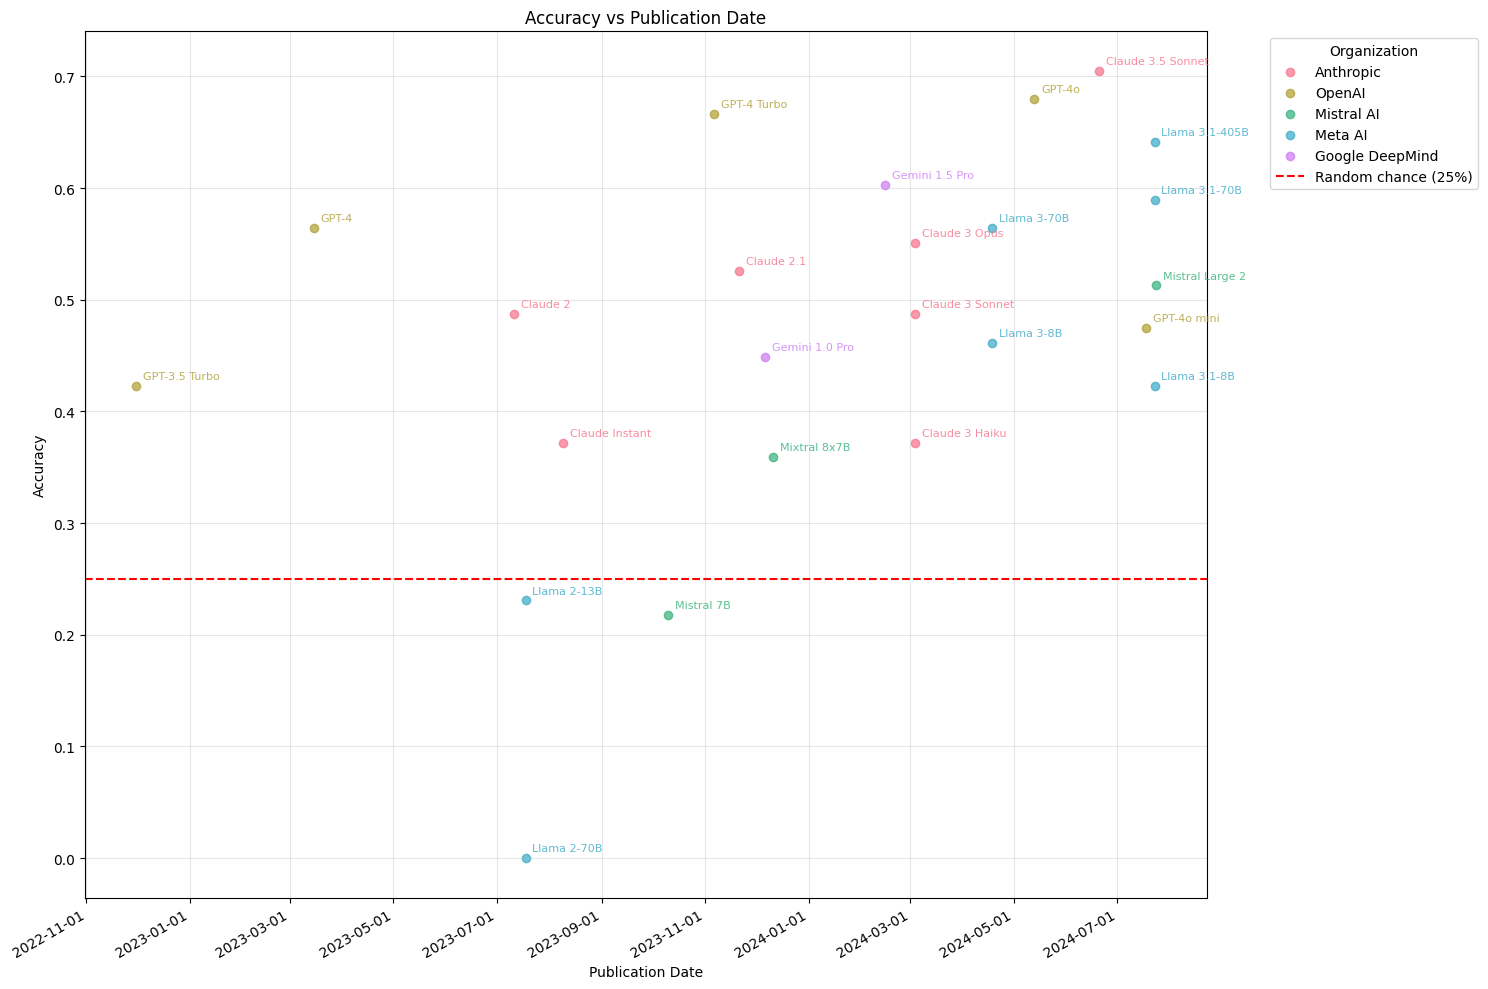

In [25]:
plot_accuracy_vs_publication_date(final_df)